In [1]:
%load_ext autoreload
%autoreload 2


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib  as mpl

from mpl_toolkits.axes_grid1 import make_axes_locatable
from argparse import Namespace as NS
from os.path import join
import yaml
import torch
from syngan.models import OjaNet, OjaRule
from syngan.post_hoc_analysis import (load_network_from_checkpoint as load,
                                      make_new_data,
                                      generate_quiver, insets, rule_wrapper,
                                      plot_2Dheatmap)

from scipy.optimize import root
from matplotlib.cbook import get_sample_data


## Load fits and make data

In [3]:
# Load test data
path_to_data = join("..", "..", "data", "oja_net_small")
test_data = np.load(join(path_to_data, "extra_test_data.npz"))

with open(join(path_to_data, "config.yaml"), "r") as f:
    sconf = NS(**yaml.full_load(f))

X, Y, PCs, weights = test_data["presyn_act"], test_data["postsyn_act"],\
test_data["presyn_pcs"], test_data["weights"]

gt_net = OjaNet(OjaRule(sconf.n_presyn_neur, sconf.n_postsyn_neur),
                sconf.update_rate,
                sconf.n_presyn_neur,
                sconf.n_postsyn_neur,
                sconf.timesteps,
                noise_amplitude=0.)


In [4]:
# For figure 4: Load all models
prefix = "../oja_net_small/"
path_to_fits = {"loc_oja_mlp": prefix + "<>",
                "mlp": prefix + "<>",
                "agg_mlp": prefix + "<>"
               }


generators = {k: load(path,
                      "oja_net_small",
                      path_to_sim_conf="../../data/oja_net_small/",
                      path_to_fit_conf="../tasks/oja_net_small/")
             for k, path in path_to_fits.items()
             }
generators["gt"] = gt_net


In [5]:
# Make new data
test_wts = {}
test_outputs = {}
test_score = {}

torch.manual_seed(786)
random_wts = 1e-1 * torch.abs(torch.randn(len(X), 1, 3, 1))
for k, network in generators.items():
    wt, y, score = make_new_data(net="OjaNet",
                                 rule=network.update_rule,
                                 presyn_act=X,
                                 wt_init_seed=786,
                                 init_weights=random_wts,
                                 return_score=True,
                                 score_funcn="pc_norm",
                                 PCs=PCs)
    test_wts[k] = wt
    test_outputs[k] = y
    test_score[k] = score


## Set figure properties

In [6]:
# Set general properties for figure
labels = {"gt": "Oja's Rule",
          "loc_oja_mlp": "Oja + Local MLP",
          "mlp": "Global MLP",
          "agg_mlp": "Semi-global MLP"}
colors = {"gt": "k",
          "loc_oja_mlp": "tab:purple",
          "agg_mlp": "tab:green",
          "mlp": "xkcd:goldenrod"}
linewidths = {"gt": 4,
              "loc_oja_mlp": 4,
              "agg_mlp": 4,
              "mlp": 4}

# Pick random set of datasets for plotting
panel_test_dataset=69
timebins = [9, 49, 199]
keys = ["loc_oja_mlp", "agg_mlp",
        "mlp"]


def get_roots():
    x = 0.5
    roots = {"gt": {"y": [-.5, 0., 0.5],
                    "w": [-1, 0., 1],
                    "init_w": [-1, 1],
                    },
             "loc_oja_mlp": {"y": [-.5, 0., .5],
                             "init_w": [-.75, 0., 1.25],
                             "w": []},
             "mlp": {"y": [-1],
                    "w": [],
                    "init_w": [-1.75]},
             "agg_mlp": {"y": [.1],
                    "w": [],
                    "init_w": [.1]}
            }

    for key in [k for k in roots.keys() if k!="gt"]:
        for yy, rand in zip(roots[key]["y"], roots[key]["init_w"]):
            rootfinder = root(rule_wrapper(generators[key].update_rule), rand, args=(x, yy),
                              method='hybr')#, jac=jac_rule(loc_mlp))
            roots[key]["w"].append(rootfinder.x)
    return roots


## Make figure

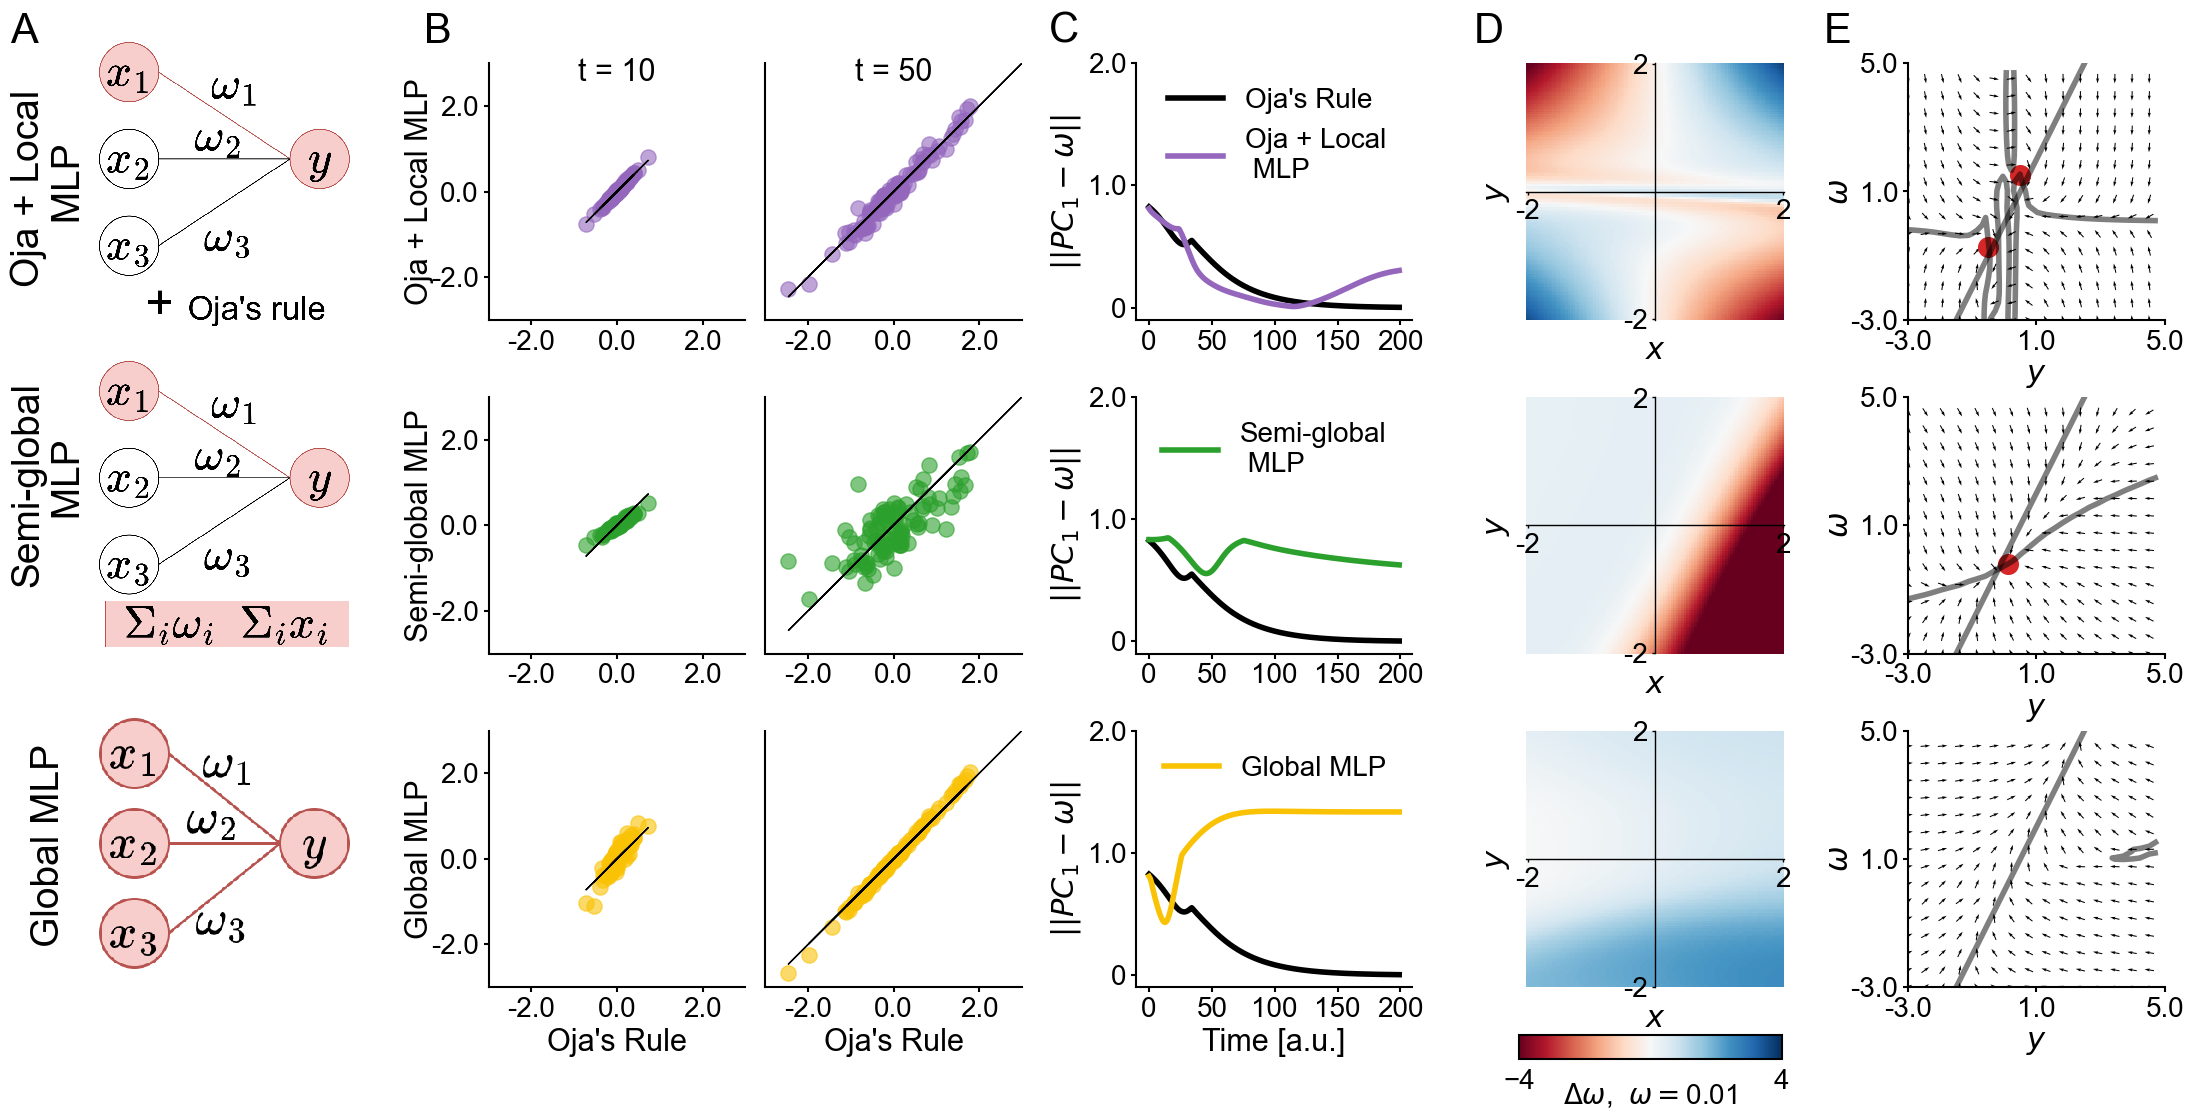

In [22]:
with mpl.rc_context(fname="./matplotlibrc"):
    fig = plt.figure(figsize=(25, 12))
    fig.patch.set_facecolor('white')
    fig.subplots_adjust(wspace=.35, hspace=.3)
    fig.tight_layout()

    gs = plt.GridSpec(3, 5, width_ratios=(1, 4, 2., 2, 2), height_ratios=(1., 1., 1.))

    # Panel A
    cartoon_prefix = "../../cartoon_%s.png"
    for i, key in enumerate(keys):
        ax = plt.subplot(gs[i*5])
        im_ax = fig.add_axes([0.07, 0.08 + 0.28 * (2 - i), .1, .3])
        im = plt.imread(get_sample_data(cartoon_prefix % key))
        im_ax.imshow(im)
        im_ax.axis('off')
        ax.axis('off')


    # Panel B
    for i, (key, pn) in enumerate(zip(keys, [panel_test_dataset]*5)):
        ax = plt.subplot(gs[i*5 + 1])
        ax.axis('off')
        for j, (t, loc) in enumerate(zip(timebins[:-1], ["left", "right"])):
            div = make_axes_locatable(ax)
            ax = div.append_axes(loc, size="100%", pad=.2)
            insets(ax, t, key, pn, colors, labels, test_outputs, ylabel=labels[key],
                   fontsize=20, labelsize=22, titlesize=22)
            if i!=2:
                ax.set_xlabel("")
            if i!=0:
                ax.set_title("")

    # Panel C
    for i, (key, pn, label) in enumerate(zip(keys, [panel_test_dataset]*3,
                                             ["Oja + Local\n MLP", "Semi-global\n MLP", "Global MLP"]
                                            )
                                        ):
        ax = plt.subplot(gs[i*5 + 2])
        ax.set_xlabel("Time [a.u.]", fontsize=22)
        ax.set_ylabel(r"$||PC_1 - \omega||$", fontsize=22)
        ax.set_xticks([0, 50, 100, 150, 200])
        ax.set_ylim(-.1, 2)
        ax.set_yticks([0, 1., 2.])
        ax.set_xticklabels(labels=[0, 50, 100, 150, 200], fontsize=20)
        ax.set_yticklabels(labels=[0, 1., 2.], fontsize=20)

        ax.plot(test_score["gt"][pn].T,
                 color=colors["gt"],
                 lw=linewidths["gt"],
                 alpha=1.,
                 label=labels["gt"] if i==0 else "")
        ax.plot(test_score[key][pn].T,
                 color=colors[key],
                 lw=linewidths[key],
                 alpha=1.,
                 label=label)
        if i!=2:
            ax.set_xlabel("")
        ax.legend(fontsize=20)

    # Panel D
    cax = fig.add_axes((.638, .05, .105, .02))

    for i, (key, colax) in enumerate(zip(keys, [None, None, cax])):
        ax = plt.subplot(gs[i*5 + 3])
        plot_2Dheatmap(rule_wrapper(generators[key].update_rule),
                       ax,
                       0.01,
                       cax=colax,
                       x_range = [-2,2],
                       y_range = [-2,2],
                       n_points = [100,100],
                       fontsize=20,
                       labelsize=22,
                       labelpad=80)


    # Panel E
    x = 0.5
    for i, (key, lim) in enumerate(zip(keys, [[-3, 5], [-3, 5], [-3, 5]])):
        ax = plt.subplot(gs[i*5 + 4])
        roots = get_roots()
        w_range = np.linspace(lim[0], lim[1], 150)
        y_range = np.linspace(lim[0], lim[1], 150)

        Y, W, DY, DW = generate_quiver(rule_wrapper(generators[key].update_rule),
                                       w_range=w_range, y_range=y_range)
        ax.quiver(Y[::2, ::2], W[::2, ::2], DY[::2, ::2], DW[::2, ::2], pivot='mid')
        ax.set_xlim(lim[0], lim[1])
        ax.set_ylim(lim[0], lim[1])
        ax.set_aspect(1)
        ax.set_xticks(np.linspace(lim[0], lim[1], 3))
        ax.set_xticklabels(np.linspace(lim[0], lim[1], 3), fontsize=20)
        ax.set_yticks(np.linspace(lim[0], lim[1], 3))
        ax.set_yticklabels(np.linspace(lim[0], lim[1], 3), fontsize=20)
        ax.set_xlabel(r"$y$", fontsize=22)
        ax.set_ylabel(r"$\omega$", fontsize=22, labelpad=-2.5)


        y_fp, w_fp = roots[key]["y"], roots[key]["w"]
        ax.contour(Y, W, DW, [0], colors="k", alpha=.5, linewidths=[4])
        ax.plot(w_range * x, w_range, lw=4, color="k", alpha=.5, label="Nullclines")
        ax.scatter(y_fp, w_fp, s=200, color="tab:red", label="Fixed pt")

#         if i==2:
#             ax.legend(frameon=True, fontsize=22, loc="lower center")

    fig.text(0.04, .897, "A", ha='center', fontsize=30)
    fig.text(0.2, .897, "B", fontsize=30)
    fig.text(0.45, .897, "C", fontsize=30)
    fig.text(0.62, .897, "D", fontsize=30)
    fig.text(0.76, .897, "E", fontsize=30)

    fig.text(0.05, .7, "Oja + Local\n MLP", fontsize=28, ha='center', rotation='vertical')
    fig.text(0.05, .45, "Semi-global\n MLP", fontsize=28, ha='center', rotation='vertical')
    fig.text(0.05, .15, "Global MLP", fontsize=28, ha='center', rotation='vertical')


    fig.savefig("fig4.jpg")
